<a href="https://colab.research.google.com/github/dietadestina/AI4Jobs_program/blob/main/Klasifikasi_SMS_(Model_NB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi SMS (Model NB)

Contoh Deloyment untuk Natural Language Processing (NLP) <br>
Orbit Future Academy - AI Mastery - KM Batch 3 <br>
Tim Deployment dan Tim NLP <br>
2022

Hari ini, kita akan menyelesaikan kasus klasifikasi SMS spam menggunakan skema seperti gambar di bawah ini.
<img src="./Process Flow.png" width=600 height=150 />

Langkah-langkah penyelesaian melitputi:
1. Data Acquisition
2. Exploratory Data Analysis (EDA)
3. Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
4. Feature Engineering
   1. Feature Extraction - TF IDF
   2. Feature Selection - Chi-Square
5. Modelling (Machine Learning)
6. Prediction
7. Model Evaluation

Pada kasus ini, kita menggunakan data set berbahasa indonesia, sehingga kita membutuhkan *Library Sastrawi* untuk menyelesaikan beberapa permasalahan seperti *stemming*.

## Modules dan Packages

In [22]:
!pip -q install sastrawi

In [23]:
!pip -q install nltk

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

import re
import nltk
nltk.download('stopwords')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import random
from joblib import dump

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Acquisition

Penjelasan Label
* 0: SMS normal
* 1: SMS fraud atau penipuan
* 2: SMS promo

In [25]:
data = pd.read_csv('dataset_sms_spam_v1.csv')
data.head()

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


## Exploratory Data Analysis (EDA)

In [27]:
print('Total Jumlah SMS:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] SMS Normal\t:', data[data.label == 0].shape[0], 'data')
print('-- [1] Fraud / Penipuan\t:', data[data.label == 1].shape[0], 'data')
print('-- [2] Promo\t\t:', data[data.label == 2].shape[0], 'data\n')

Total Jumlah SMS: 1143 data

terdiri dari (label):
-- [0] SMS Normal	: 569 data
-- [1] Fraud / Penipuan	: 335 data
-- [2] Promo		: 239 data



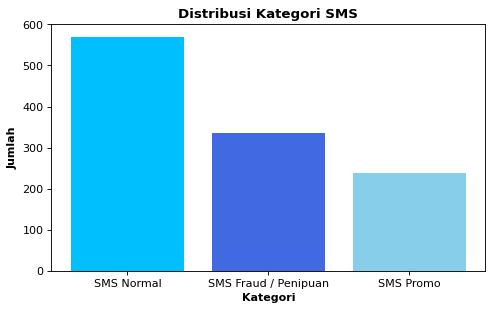

In [28]:
height = data['label'].value_counts()
labels = ('SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo')
y_pos  = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Kategori SMS', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

## Text Preprocessing

### Case Folding

In [29]:
# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [30]:
raw_sample   = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding	:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel


### Word Normalization

In [31]:
key_norm = pd.read_csv('key_norm.csv')

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

### Filtering (Stopword Removal)

In [32]:
stopwords_ind = stopwords.words('indonesian')

In [33]:
len(stopwords_ind)

758

In [34]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [35]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['tsel', 'gb', 'rb']                    # Tambahkan kata dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [36]:
raw_sample       = data['teks'].iloc[5]
case_folding     = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel


### Stemming

In [37]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [38]:
raw_sample       = data['teks'].iloc[5]
case_folding     = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming    = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel
Stemming		:  ekstra pulsa dg beli paket internet bulan mytelkomsel utk beli sjk augsept cek detail promo tselmemytsel


### Text Preprocessing Pipeline

In [39]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [40]:
%%time
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 6min 43s, sys: 1.93 s, total: 6min 45s
Wall time: 7min 3s


In [41]:
data

,teks,label,clean_teks
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo beli paket flash my telkomsel app extra ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,rupiah ribu spesial pilih aktif promo sd novem...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,rupiah ribu spesial pilih aktif buru skb
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,nulis kerudung kirain warna jins
1140,Mba mau kirim 300 ya,0,mbak kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,nama beaok bwrangkat pagimau cas atay tranfer


In [42]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

## Feature Engineering

In [43]:
# Pisahkan kolom feature dan target
X = data['clean_teks']
y = data['label']

In [44]:
X

,clean_teks
0,promo beli paket flash my telkomsel app extra ...
1,rupiah ribu spesial pilih aktif promo sd novem...
2,pulang hormat sisa kuota flash kb download myt...
3,pulang hormat sisa kuota flash kb download myt...
4,rupiah ribu spesial pilih aktif buru skb
...,...
1138,yooo oke umumin grup kelas
1139,nulis kerudung kirain warna jins
1140,mbak kirim ya
1141,nama beaok bwrangkat pagimau cas atay tranfer


In [45]:
y

,label
0,2
1,2
2,2
3,2
4,2
...,...
1138,0
1139,0
1140,0
1141,0


### Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [46]:
tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [49]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

3253


In [51]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aamiiiin' 'aamiin' ... 'zjt' 'zona' 'ztkm']


In [52]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

### Feature Selection

In [56]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [57]:
# Ten features with highest chi-squared statistics are selected
chi2_features    = SelectKBest(chi2, k=1000)
X_kbest_features = chi2_features.fit_transform(X, y)

# Reduced features
print('Original feature number:', X.shape[1])
print('Reduced feature number:', X_kbest_features.shape[1])

Original feature number: 3253
Reduced feature number: 1000


In [58]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.835608
1,0.419698
2,1.558607
3,0.716455
4,0.800674
...,...
3248,1.180239
3249,0.503162
3250,0.716455
3251,2.917381


In [60]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.835608,aa
1,0.419698,aamiiiin
2,1.558607,aamiin
3,0.716455,ab
4,0.800674,abadi
...,...,...
3248,1.180239,zalora
3249,0.503162,zarkasi
3250,0.716455,zjt
3251,2.917381,zona


In [61]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
2088,49.062970,paket
1030,46.324101,hadiah
1549,45.593560,kuota
2178,39.438431,pin
1486,34.448410,klik
...,...,...
1520,0.044910,kopi
307,0.044468,bca
1694,0.031579,maksimal
531,0.013783,cepat


In [62]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False,  True, ..., False,  True, False])

In [63]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aamiin',
 'agam',
 'agen',
 'ags',
 'agst',
 'agsts',
 'agt',
 'agtskinfodlj',
 'agun',
 'agustuskunjungi',
 'ajak',
 'akses',
 'aktif',
 'aktivasi',
 'alam',
 'alamsyah',
 'aliando',
 'all',
 'aman',
 'amanda',
 'an',
 'anda',
 'andabch',
 'andika',
 'andromax',
 'angga',
 'angpaopoinsenyum',
 'angsur',
 'anrasto',
 'ap',
 'apa',
 'aplikasi',
 'app',
 'appleplay',
 'apps',
 'appsinapps',
 'argo',
 'armada',
 'artha',
 'artisartis',
 'arya',
 'as',
 'asa',
 'asli',
 'ass',
 'assalamualaikum',
 'at',
 'atas',
 'ato',
 'aug',
 'augsept',
 'avanza',
 'axiata',
 'axis',
 'axisnet',
 'ayah',
 'ayam',
 'ayo',
 'bagi',
 'baik',
 'bakmi',
 'balas',
 'ball',
 'bandung',
 'bandungmulai',
 'bang',
 'banget',
 'bank',
 'banting',
 'banyak',
 'bapa',
 'bareng',
 'barokahmp',
 'baru',
 'baruqskrng',
 'baskin',
 'batas',
 'batin',
 'bawa',
 'bayar',
 'bb',
 'bbm',
 'bch',
 'bebek',
 'beda',
 'belanja',
 'beli',
 'beliau',
 'belikan',
 'bentar',
 'berangkat',
 'beres',
 'berkat',
 'berlakupromo',
 '

In [64]:
# Memilih fitur yang telah terseleksi dari vocabulary TF IDF
kbest_feature = {}

for (k,v) in tf_idf.vocabulary_.items():
  if k in selected_feature:
    kbest_feature[k] = v

In [65]:
len(kbest_feature)

1000

In [66]:
# Menampilkan fitur-fitur yang sudah diseleksi
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,agam,agen,ags,agst,agsts,agt,agtskinfodlj,agun,agustuskunjungi,...,yesok,your,yrkz,ytg,ythmohon,ythsaya,yuk,yunit,zalora,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

## Modelling (Machine Learning)

In [68]:
# Memisihkan data training dan data testing dengan perbandingan 80:20
X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=0)

In [76]:
# Training Model
algorithm = MultinomialNB()
model_NB  = algorithm.fit(X_train, y_train)

In [77]:
from sklearn.svm import SVC

# Training Model dengan SVM
algorithm = SVC(kernel='linear')
model_SVM = algorithm.fit(X_train, y_train)

In [86]:
from sklearn.linear_model import LogisticRegression

# Training Model dengan Logistic Regression
algorithm = LogisticRegression(max_iter=1000)  # max_iter ditambah jika model butuh lebih banyak iterasi
model_LR  = algorithm.fit(X_train, y_train)

In [94]:
# Import library XGBoost
from xgboost import XGBClassifier

# Training Model dengan XGBoost
algorithm = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_XGB = algorithm.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:14:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [100]:
# Import library Random Forest
from sklearn.ensemble import RandomForestClassifier

# Training Model dengan Random Forest
algorithm = RandomForestClassifier(n_estimators=100, random_state=42)  # n_estimators bisa disesuaikan untuk eksperimen
model_RFC = algorithm.fit(X_train, y_train)

In [133]:
# Import library MLP Classifier
from sklearn.neural_network import MLPClassifier

# Training Model dengan MLP
algorithm = MLPClassifier(hidden_layer_sizes=(50), max_iter=300, random_state=42)  # Sesuaikan hidden_layer_sizes sesuai kebutuhan
model_MLP = algorithm.fit(X_train, y_train)

## Prediction

In [78]:
# Prediksi untuk Data Latih
predicted_train_NB = model_NB.predict(X_train)

# hasil ini akan kita bandingkan dengan nilai y_train (labeling dari manusia)
predicted_train_NB[1:20]

array([2, 2, 0, 2, 0, 2, 1, 2, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1])

In [80]:
# Prediksi untuk Data Uji
predicted_test_NB = model_NB.predict(X_test)

# hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted_test_NB[1:20]

array([2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0])

In [79]:
# Prediksi untuk Data Latih
predicted_train_SVM = model_SVM.predict(X_train)

# hasil ini akan kita bandingkan dengan nilai y_train (labeling dari manusia)
predicted_train_SVM[1:20]

array([2, 2, 0, 2, 0, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1])

In [81]:
# Prediksi untuk Data Uji
predicted_test_SVM = model_SVM.predict(X_test)

# hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted_test_SVM[1:20]

array([2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0])

In [87]:
# Prediksi untuk Data Latih
predicted_train_LR = model_LR.predict(X_train)

# hasil ini akan kita bandingkan dengan nilai y_train (labeling dari manusia)
predicted_train_LR[1:20]

array([2, 2, 0, 2, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1])

In [88]:
# Prediksi untuk Data Uji
predicted_test_LR = model_LR.predict(X_test)

# hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted_test_LR[1:20]

array([2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0])

In [95]:
# Prediksi untuk Data Latih
predicted_train_XGB = model_XGB.predict(X_train)

# hasil ini akan kita bandingkan dengan nilai y_train (labeling dari manusia)
predicted_train_XGB[1:20]

array([2, 2, 1, 2, 0, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1])

In [96]:
# Prediksi untuk Data Uji
predicted_test_XGB = model_XGB.predict(X_test)

# hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted_test_XGB[1:20]

array([2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0])

In [102]:
# Prediksi untuk Data Latih
predicted_train_RFC = model_RFC.predict(X_train)

# hasil ini akan kita bandingkan dengan nilai y_train (labeling dari manusia)
predicted_train_RFC[1:20]

array([2, 2, 1, 2, 0, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1])

In [103]:
# Prediksi untuk Data Uji
predicted_test_RFC = model_RFC.predict(X_test)

# hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted_test_RFC[1:20]

array([2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0])

In [134]:
# Prediksi untuk Data Latih
predicted_train_MLP = model_MLP.predict(X_train)

# hasil ini akan kita bandingkan dengan nilai y_train (labeling dari manusia)
predicted_train_MLP[1:20]

array([2, 2, 1, 2, 0, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1])

In [135]:
# Prediksi untuk Data Uji
predicted_test_MLP = model_MLP.predict(X_test)

# hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted_test_MLP[1:20]

array([2, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0])

# Model Evaluation

In [82]:
# Perhitungan Performa Model untuk Data Latih
CM = confusion_matrix(y_train, predicted_train_NB)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_train, predicted_train_NB)*100,"%\n")

print(classification_report(y_train,predicted_train_NB))

[[433   3   7]
 [ 12 249   8]
 [  7   5 190]] 

ACCURACY	: 95.40481400437638 %

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       443
           1       0.97      0.93      0.95       269
           2       0.93      0.94      0.93       202

    accuracy                           0.95       914
   macro avg       0.95      0.95      0.95       914
weighted avg       0.95      0.95      0.95       914



In [84]:
# Perhitungan Performa Model untuk Data Uji
CM = confusion_matrix(y_test, predicted_test_NB)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_test, predicted_test_NB)*100,"%\n")

print(classification_report(y_test,predicted_test_NB))

[[120   4   2]
 [  7  58   1]
 [  3   3  31]] 

ACCURACY	: 91.26637554585153 %

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       126
           1       0.89      0.88      0.89        66
           2       0.91      0.84      0.87        37

    accuracy                           0.91       229
   macro avg       0.91      0.89      0.90       229
weighted avg       0.91      0.91      0.91       229



In [83]:
# Perhitungan Performa Model untuk Data Latih
CM = confusion_matrix(y_train, predicted_train_SVM)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_train, predicted_train_SVM)*100,"%\n")

print(classification_report(y_train,predicted_train_SVM))

[[438   0   5]
 [ 17 249   3]
 [  5   1 196]] 

ACCURACY	: 96.60831509846827 %

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       443
           1       1.00      0.93      0.96       269
           2       0.96      0.97      0.97       202

    accuracy                           0.97       914
   macro avg       0.97      0.96      0.97       914
weighted avg       0.97      0.97      0.97       914



In [97]:
# Perhitungan Performa Model untuk Data Uji
CM = confusion_matrix(y_test, predicted_test_SVM)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_test, predicted_test_SVM)*100,"%\n")

print(classification_report(y_test,predicted_test_SVM))

[[120   3   3]
 [  7  57   2]
 [  5   2  30]] 

ACCURACY	: 90.39301310043668 %

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       126
           1       0.92      0.86      0.89        66
           2       0.86      0.81      0.83        37

    accuracy                           0.90       229
   macro avg       0.90      0.88      0.88       229
weighted avg       0.90      0.90      0.90       229



In [89]:
# Perhitungan Performa Model untuk Data Latih
CM = confusion_matrix(y_train, predicted_train_LR)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_train, predicted_train_LR)*100,"%\n")

print(classification_report(y_train,predicted_train_LR))

[[440   0   3]
 [ 22 243   4]
 [ 17   4 181]] 

ACCURACY	: 94.52954048140045 %

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       443
           1       0.98      0.90      0.94       269
           2       0.96      0.90      0.93       202

    accuracy                           0.95       914
   macro avg       0.96      0.93      0.94       914
weighted avg       0.95      0.95      0.94       914



In [90]:
# Perhitungan Performa Model untuk Data Uji
CM = confusion_matrix(y_test, predicted_test_LR)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_test, predicted_test_LR)*100,"%\n")

print(classification_report(y_test,predicted_test_LR))

[[121   3   2]
 [  8  57   1]
 [  6   2  29]] 

ACCURACY	: 90.39301310043668 %

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       126
           1       0.92      0.86      0.89        66
           2       0.91      0.78      0.84        37

    accuracy                           0.90       229
   macro avg       0.91      0.87      0.89       229
weighted avg       0.90      0.90      0.90       229



In [98]:
# Perhitungan Performa Model untuk Data Latih
CM = confusion_matrix(y_train, predicted_train_XGB)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_train, predicted_train_XGB)*100,"%\n")

print(classification_report(y_train,predicted_train_XGB))

[[443   0   0]
 [  3 266   0]
 [  1   0 201]] 

ACCURACY	: 99.56236323851203 %

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       443
           1       1.00      0.99      0.99       269
           2       1.00      1.00      1.00       202

    accuracy                           1.00       914
   macro avg       1.00      0.99      1.00       914
weighted avg       1.00      1.00      1.00       914



In [99]:
# Perhitungan Performa Model untuk Data Uji
CM = confusion_matrix(y_test, predicted_test_XGB)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_test, predicted_test_XGB)*100,"%\n")

print(classification_report(y_test,predicted_test_XGB))

[[117   4   5]
 [  6  59   1]
 [  3   4  30]] 

ACCURACY	: 89.95633187772926 %

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       126
           1       0.88      0.89      0.89        66
           2       0.83      0.81      0.82        37

    accuracy                           0.90       229
   macro avg       0.88      0.88      0.88       229
weighted avg       0.90      0.90      0.90       229



In [104]:
# Perhitungan Performa Model untuk Data Latih
CM = confusion_matrix(y_train, predicted_train_RFC)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_train, predicted_train_RFC)*100,"%\n")

print(classification_report(y_train,predicted_train_RFC))

[[443   0   0]
 [  0 269   0]
 [  0   0 202]] 

ACCURACY	: 100.0 %

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       443
           1       1.00      1.00      1.00       269
           2       1.00      1.00      1.00       202

    accuracy                           1.00       914
   macro avg       1.00      1.00      1.00       914
weighted avg       1.00      1.00      1.00       914



In [105]:
# Perhitungan Performa Model untuk Data Uji
CM = confusion_matrix(y_test, predicted_test_RFC)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_test, predicted_test_RFC)*100,"%\n")

print(classification_report(y_test,predicted_test_RFC))

[[118   4   4]
 [  6  59   1]
 [  4   2  31]] 

ACCURACY	: 90.82969432314411 %

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       126
           1       0.91      0.89      0.90        66
           2       0.86      0.84      0.85        37

    accuracy                           0.91       229
   macro avg       0.90      0.89      0.89       229
weighted avg       0.91      0.91      0.91       229



In [137]:
# Perhitungan Performa Model untuk Data Latih
CM = confusion_matrix(y_train, predicted_train_MLP)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_train, predicted_train_MLP)*100,"%\n")

print(classification_report(y_train,predicted_train_MLP))

[[443   0   0]
 [  0 269   0]
 [  0   0 202]] 

ACCURACY	: 100.0 %

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       443
           1       1.00      1.00      1.00       269
           2       1.00      1.00      1.00       202

    accuracy                           1.00       914
   macro avg       1.00      1.00      1.00       914
weighted avg       1.00      1.00      1.00       914



In [136]:
# Perhitungan Performa Model untuk Data Uji
CM = confusion_matrix(y_test, predicted_test_MLP)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_test, predicted_test_MLP)*100,"%\n")

print(classification_report(y_test,predicted_test_MLP))

[[123   3   0]
 [  4  61   1]
 [  3   2  32]] 

ACCURACY	: 94.32314410480349 %

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       126
           1       0.92      0.92      0.92        66
           2       0.97      0.86      0.91        37

    accuracy                           0.94       229
   macro avg       0.95      0.92      0.93       229
weighted avg       0.94      0.94      0.94       229



## Menyimpan Model

In [139]:
# save the model to disk
dump(model_MLP, filename="model_spam_tfidf_nb.model")

['model_spam_tfidf_nb.model']